# IMPORT LIBRARIES

In [82]:
# DATA MANUPULATION
import numpy as np
import pandas as pd

# DATA VISULATION
import matplotlib.pyplot as plt
%matplotlib inline

# DATA PREPROCESSING
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# MODEL GENERATION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

# MODEL TUNING
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
x = np.linspace(0,50, 501)

In [5]:
y = np.sin(x)

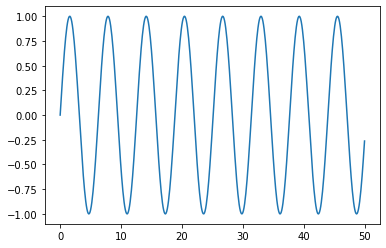

In [6]:
plt.plot(x,y)

In [7]:
df = pd.DataFrame(data=y, index =x, columns=['Sine'])

In [8]:
df

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


### SPLITING THE DATA INTO TRAIN & TEST

In [9]:
len(df)

501

In [10]:
test_percent = 0.1

In [11]:
len(df)*test_percent

50.1

In [12]:
test_point = np.round(len(df)*test_percent)

In [13]:
test_point

50.0

In [14]:
test_index = int(len(df) - test_point)

In [15]:
train = df.iloc[:test_index]

In [16]:
test = df.iloc[test_index:]

### SCALING THE DATA

In [20]:
scaler = MinMaxScaler()

In [21]:
scaler_train = scaler.fit_transform(train)

In [22]:
scalert_test = scaler.transform(test)

### CREATE BATCHES & MODEL GENERATION

In [46]:
length = 50
batch_size = 1

generator = TimeseriesGenerator(scaler_train, scaler_train, 
                                length=length, batch_size=batch_size)

In [47]:
len(scaler_train)

451

In [48]:
len(generator)

401

In [49]:
#X,y = generator[0]

In [50]:
#X

In [51]:
y

array([[0.79923759]])

In [52]:
#scaler_train

In [54]:
n_features = 1

In [106]:
model = Sequential()

model.add(SimpleRNN(50,input_shape = (length, n_features)))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [107]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.fit_generator(generator, epochs=5)

Epoch 1/5
402/402 [==============================] - 13s 34ms/step - loss: 0.0019
Epoch 2/5
402/402 [==============================] - 14s 34ms/step - loss: 3.0201e-05 ETA: 8s - loss:  -
Epoch 3/5
402/402 [==============================] - 13s 32ms/step - loss: 3.2446e-04
Epoch 4/5
402/402 [==============================] - 12s 29ms/step - loss: 5.4183e-06
Epoch 5/5
402/402 [==============================] - 12s 31ms/step - loss: 1.6258e-06


In [109]:
losses = pd.DataFrame(model.history.history)

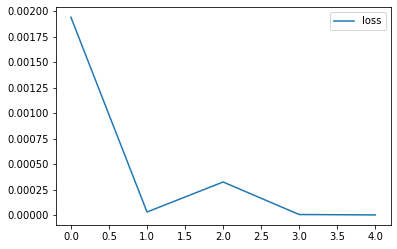

In [110]:
losses.plot()

In [111]:
first_eval_batch = scaler_train[-length:]

In [112]:
first_eval_batch = first_eval_batch.reshape(1,length, n_features)

In [113]:
model.predict(first_eval_batch)

array([[0.873181]], dtype=float32)

In [114]:
scalert_test[0]

array([0.94955134])

In [115]:
test_predictions = []

first_eval_batch = scaler_train[-length:]
current_bacth = first_eval_batch.reshape(1,length, n_features)

for i in range(len(test)):
    current_pred = model.predict(current_bacth)[0]
    
    test_predictions.append(current_pred)
    
    current_bacth = np.append(current_bacth[:,1:,:],[[current_pred]],axis=1)

In [102]:
#test_predictions

<ipython-input-116-26b683e1778a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


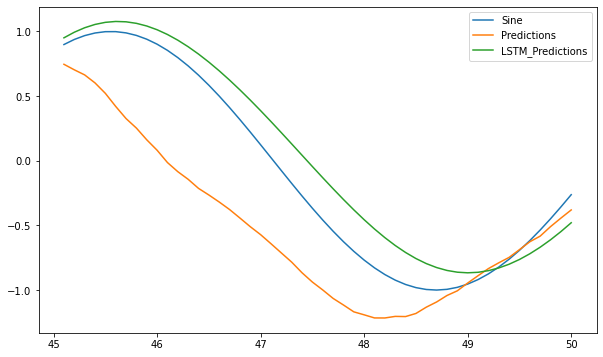

In [116]:
true_pred = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_pred
test.plot(figsize=(10,6))

### EARLY STOPPING

In [117]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [118]:
# CREATE A VALIDATION GENERATOR

generator = TimeseriesGenerator(scaler_train,scaler_train,
                               length = length - 1, batch_size=batch_size)

validation_generator = TimeseriesGenerator(scalert_test, scalert_test,
                                          length= length-1, batch_size=batch_size)

In [119]:
model = Sequential()

model.add(LSTM(50,input_shape = (length, n_features)))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [120]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator,
                   callbacks=early_stop)

Epoch 1/20
402/402 [==============================] - 22s 55ms/step - loss: 0.0133 - val_loss: 4.3850e-05
Epoch 2/20
402/402 [==============================] - 22s 55ms/step - loss: 2.4778e-04 - val_loss: 1.5703e-04
Epoch 3/20
402/402 [==============================] - 20s 49ms/step - loss: 2.0251e-04 - val_loss: 4.8295e-05


In [121]:
test_predictions = []

first_eval_batch = scaler_train[-length:]
current_bacth = first_eval_batch.reshape(1,length, n_features)

for i in range(len(test)):
    current_pred = model.predict(current_bacth)[0]
    
    test_predictions.append(current_pred)
    
    current_bacth = np.append(current_bacth[:,1:,:],[[current_pred]],axis=1)

<ipython-input-122-11ad3d7b38eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM_Predictions'] = true_pred


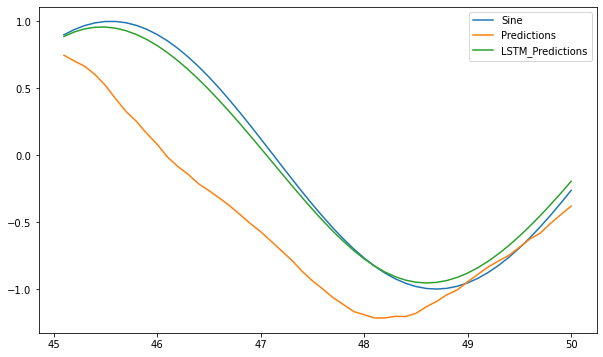

In [122]:
true_pred = scaler.inverse_transform(test_predictions)
test['LSTM_Predictions'] = true_pred
test.plot(figsize=(10,6))

### FORECASTING

In [123]:
full_scaler = MinMaxScaler()

In [124]:
scaled_full_data =full_scaler.fit_transform(df)

In [125]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,
                               length = length - 1, batch_size=batch_size)

In [126]:
model = Sequential()

model.add(LSTM(50,input_shape = (length, n_features)))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [127]:
model.fit_generator(generator,epochs=3)

Epoch 1/3
452/452 [==============================] - 18s 41ms/step - loss: 0.0096
Epoch 2/3
452/452 [==============================] - 18s 40ms/step - loss: 1.3257e-04
Epoch 3/3
452/452 [==============================] - 20s 43ms/step - loss: 3.3421e-04


In [137]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_bacth = first_eval_batch.reshape(1,length, n_features)

for i in range(50):
    current_pred = model.predict(current_bacth)[0]
    
    forecast.append(current_pred)
    
    current_bacth = np.append(current_bacth[:,1:,:],[[current_pred]],axis=1)

In [138]:
forecast = scaler.inverse_transform(forecast)

In [141]:
forecast_index = np.arange(50.1,(50.1+(50*0.1)), step=0.1)

In [142]:
len(forecast_index)

50

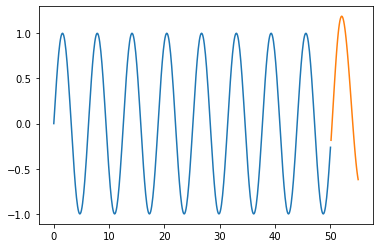

In [143]:
plt.plot(df.index, df['Sine'])
plt.plot(forecast_index,forecast)